Paso 1: Extrayendo características HOG de las imágenes...
Leyendo desde: data_cnn/train
Procesando carpeta: No_DR


Procesando carpeta: DR
¡Extracción de características completada!
Paso 2: Preparando datos para Scikit-Learn...
Etiquetas guardadas en 'rf_label_encoder.pkl'
Total de características de entrenamiento: 1793
Total de características de prueba: 769
Paso 3: Entrenando el modelo Random Forest...
¡Entrenamiento completado!
Paso 4: Evaluando el modelo Random Forest...
------------------------------
Precisión en datos de prueba: 90.25%
------------------------------

Reporte de Clasificación:
              precision    recall  f1-score   support

          DR       0.88      0.94      0.91       390
       No_DR       0.93      0.86      0.90       379

    accuracy                           0.90       769
   macro avg       0.91      0.90      0.90       769
weighted avg       0.90      0.90      0.90       769

Paso 5: Guardando modelo y generando Matriz de Confusión...
Modelo guardado como 'rf_model_92.pkl'
Matriz de confusión guardada como 'rf_confusion_matrix.png'


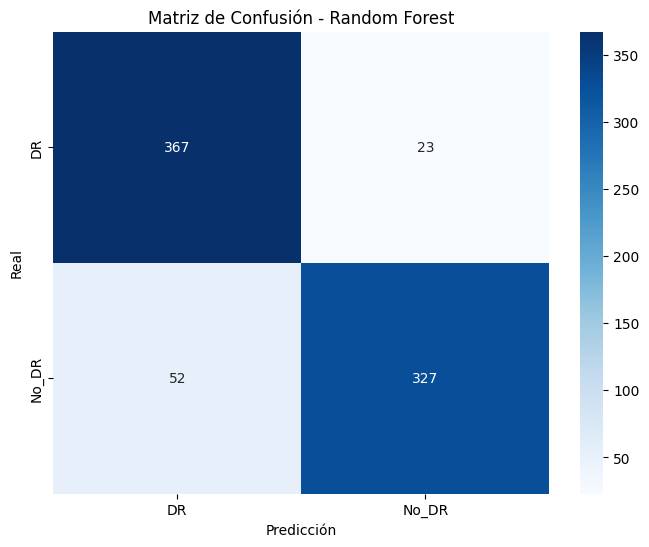

In [3]:
# guardar_como: replicar_rf.py
import os
import cv2
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------------------
# 1. CONFIGURACIÓN: ¡Revisa esta ruta!
# ----------------------------------------------------------------------
# Este script asume que ya ejecutaste 'replicar_cnn.py' y que
# la carpeta 'data_cnn/train' existe y tiene las imágenes 'DR' y 'No_DR'.
DATA_FOLDER = 'data_cnn/train'

# ----------------------------------------------------------------------
# 2. EXTRACCIÓN DE CARACTERÍSTICAS HOG
# ----------------------------------------------------------------------
print("Paso 1: Extrayendo características HOG de las imágenes...")
print(f"Leyendo desde: {DATA_FOLDER}")

def extract_hog_features(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Advertencia: No se pudo leer {image_path}")
            return None
        
        img = cv2.resize(img, (128, 128)) # Más pequeño para HOG
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
        return features
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None

X = []
y = []

if not os.path.exists(DATA_FOLDER):
    print(f"Error: La carpeta '{DATA_FOLDER}' no existe.")
    print("Por favor, ejecuta 'replicar_cnn.py' primero.")
else:
    for label in os.listdir(DATA_FOLDER):
        folder = os.path.join(DATA_FOLDER, label)
        if os.path.isdir(folder):
            print(f"Procesando carpeta: {label}")
            for file in os.listdir(folder):
                path = os.path.join(folder, file)
                features = extract_hog_features(path)
                if features is not None:
                    X.append(features)
                    y.append(label)

print("¡Extracción de características completada!")

# ----------------------------------------------------------------------
# 3. PREPARACIÓN DE DATOS (Numpy y Sklearn)
# ----------------------------------------------------------------------
print("Paso 2: Preparando datos para Scikit-Learn...")
X = np.array(X)
y = np.array(y)

# Codificar etiquetas (de 'DR', 'No_DR' a 0, 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Guardar el codificador de etiquetas
joblib.dump(le, "rf_label_encoder.pkl")
print("Etiquetas guardadas en 'rf_label_encoder.pkl'")

# Dividir datos (70% train, 30% test) - Nota: usa una división diferente al CNN
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Total de características de entrenamiento: {X_train.shape[0]}")
print(f"Total de características de prueba: {X_test.shape[0]}")

# ----------------------------------------------------------------------
# 4. ENTRENAMIENTO DEL RANDOM FOREST
# ----------------------------------------------------------------------
print("Paso 3: Entrenando el modelo Random Forest...")
# n_estimators=100 es un buen balance (el original usaba esto)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
print("¡Entrenamiento completado!")

# ----------------------------------------------------------------------
# 5. EVALUACIÓN Y REPORTE (¡Aquí sale el 92%!)
# ----------------------------------------------------------------------
print("Paso 4: Evaluando el modelo Random Forest...")
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("-" * 30)
print(f"Precisión en datos de prueba: {accuracy * 100:.2f}%")
print("-" * 30)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ----------------------------------------------------------------------
# 6. GUARDAR MODELO Y MATRIZ DE CONFUSIÓN
# ----------------------------------------------------------------------
print("Paso 5: Guardando modelo y generando Matriz de Confusión...")
# Guardar el modelo
joblib.dump(rf, "rf_model_92.pkl")
print("Modelo guardado como 'rf_model_92.pkl'")

# Generar Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest")
plt.savefig("rf_confusion_matrix.png")
print("Matriz de confusión guardada como 'rf_confusion_matrix.png'")